In [18]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
## CHANGE
prepend_name="onek_"
experiment_name = "training_objectives"

metric = "avg_reward_in_topk_modes"
mode = "max"
top_percent = 0.5 # for calculating the distribution of the top_percent% of the data
percentile = 95

In [20]:
if mode == "max":
    ascending = False
elif mode == "min":
    ascending = True

In [21]:
# Find all folders in the directory
names = os.listdir(f'./logs/{prepend_name}{experiment_name}')
dataframes = [pd.read_csv(f'./logs/{prepend_name}{experiment_name}/{name}/dataframe.csv') for name in names]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,val_offline_loss,val_online_loss,val_reward_loss,val_invalid_trajectories,val_invalid_logprob,val_invalid_losses,val_logZ,val_loss,avg_topk,avg_reward_in_topk_modes,...,config/replay/insertion/sim_thresh,config/replay/insertion/strategy,config/replay/sampling/strategy,config/task/tdc/oracle,config/replay/sampling/quantile/alpha,config/replay/sampling/quantile/beta,config/replay/sampling/weighted/reward_power,logdir,val_intermediate_loss,val_terminal_loss
0,0.0,1.113477,0.0,0.0,0.0,0.0,46.195255,1.113477,0.431408,0.431280,...,0.7,fifo,uniform,qed,0.1,0.5,1.0,/home/mila/a/anja.surina/gflownet/logs/onek_tr...,NaN,NaN
1,0.0,2.301549,0.0,0.0,0.0,0.0,45.061996,2.301549,0.448512,0.447330,...,0.7,fifo,uniform,qed,0.1,0.5,1.0,/home/mila/a/anja.surina/gflownet/logs/onek_tr...,NaN,NaN
2,0.0,2.502635,0.0,0.0,0.0,0.0,42.984737,2.502635,0.450840,0.449887,...,0.7,fifo,uniform,qed,0.1,0.5,1.0,/home/mila/a/anja.surina/gflownet/logs/onek_tr...,NaN,NaN
3,0.0,21.033089,0.0,0.0,0.0,0.0,22.713418,21.033089,0.745405,0.744499,...,0.7,fifo,uniform,qed,0.1,0.5,1.0,/home/mila/a/anja.surina/gflownet/logs/onek_tr...,NaN,NaN
4,0.0,10.027497,0.0,0.0,0.0,0.0,44.013615,10.027497,0.127599,0.126858,...,0.7,fifo,uniform,drd2,0.1,0.5,1.0,/home/mila/a/anja.surina/gflownet/logs/onek_tr...,NaN,NaN


In [22]:
df["config/algo/helper"].value_counts(), df["config/task/helper"].value_counts()

(config/algo/helper
 DB        12
 TB        12
 SubTB1    12
 FM         7
 Name: count, dtype: int64,
 config/task/helper
 seh_frag     16
 qed_frag     14
 drd2_frag    13
 Name: count, dtype: int64)

In [23]:
tasks = list(df["config/task/helper"].unique())

In [24]:
#Separate the dataframes by task
dfs = {task: df[df["config/task/helper"] == task] for task in tasks}

In [25]:
# Depending on the experimens, we specify what to compare by
if experiment_name == "training_objectives":
    column_name = "config/algo/helper"
elif experiment_name == "exploration":
    #TODO
    column_name = "config/replay/sampling/strategy"
methods = list(df[column_name].unique())

TASK: qed_frag
count    14.000000
mean      0.462991
std       0.109166
min       0.221109
25%       0.435624
50%       0.456267
75%       0.476461
max       0.744499
Name: avg_reward_in_topk_modes, dtype: float64





TASK: drd2_frag
count    13.000000
mean      0.107976
std       0.015332
min       0.087234
25%       0.092939
50%       0.111420
75%       0.119232
max       0.133257
Name: avg_reward_in_topk_modes, dtype: float64



TASK: seh_frag
count    16.000000
mean      0.811612
std       0.020727
min       0.782131
25%       0.797315
50%       0.805844
75%       0.830974
max       0.852689
Name: avg_reward_in_topk_modes, dtype: float64





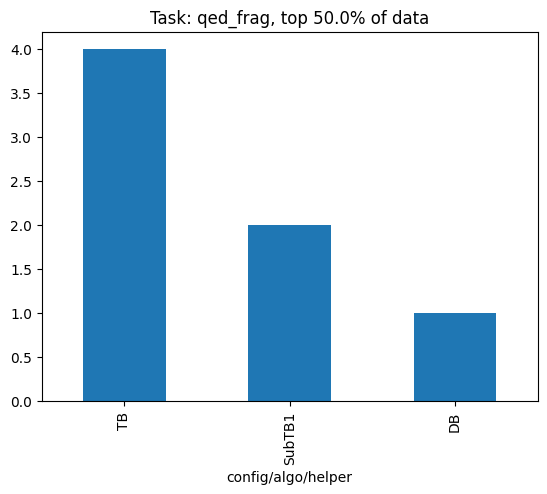

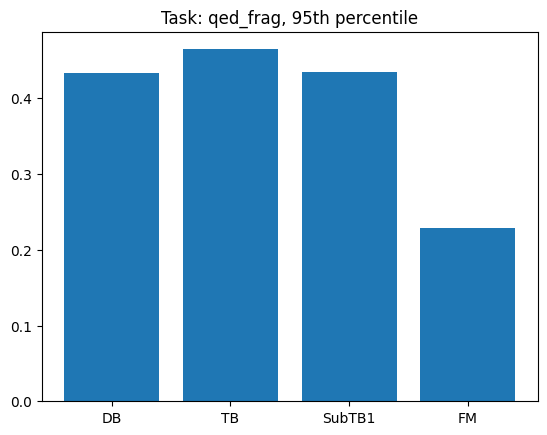

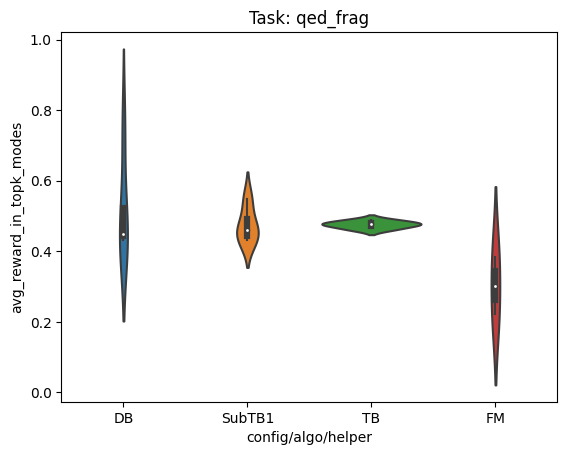

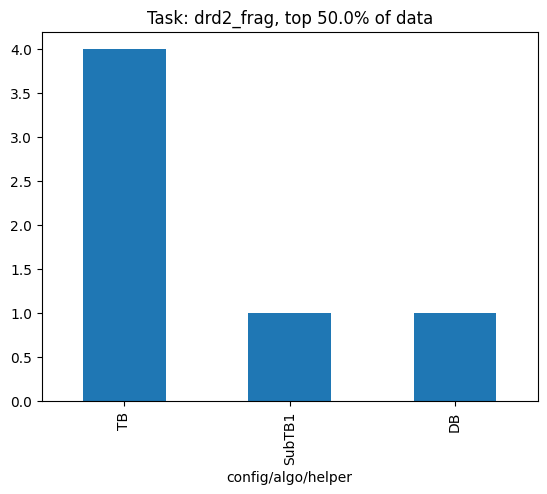

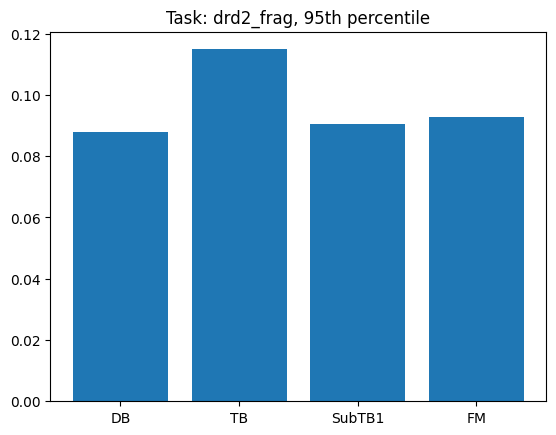

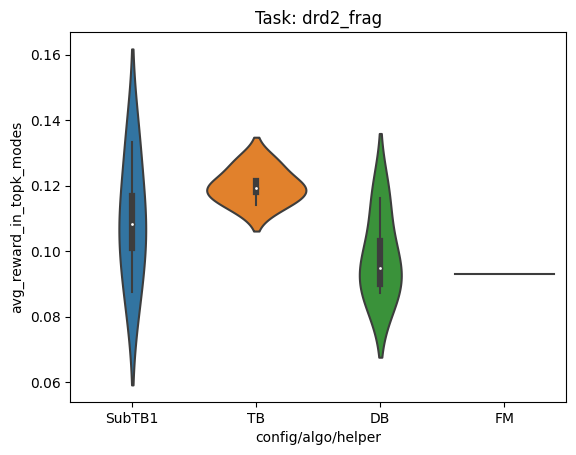

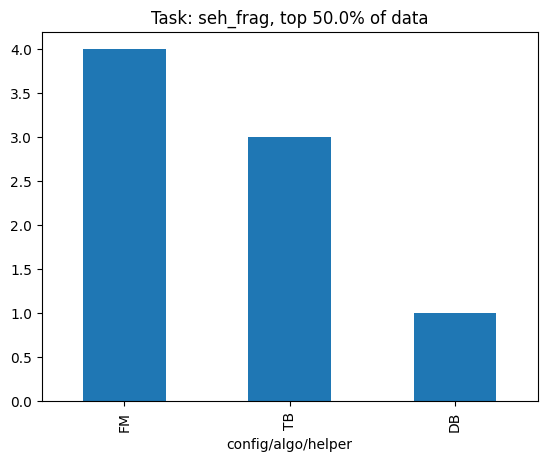

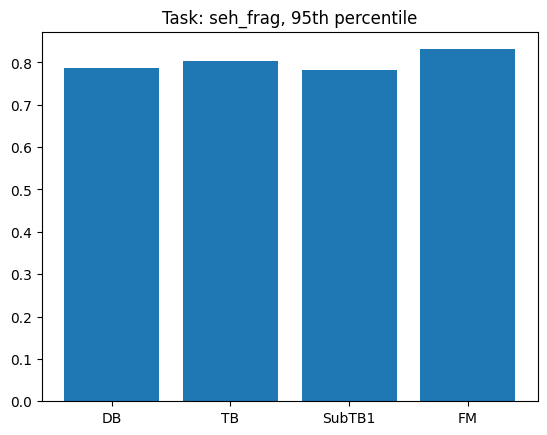

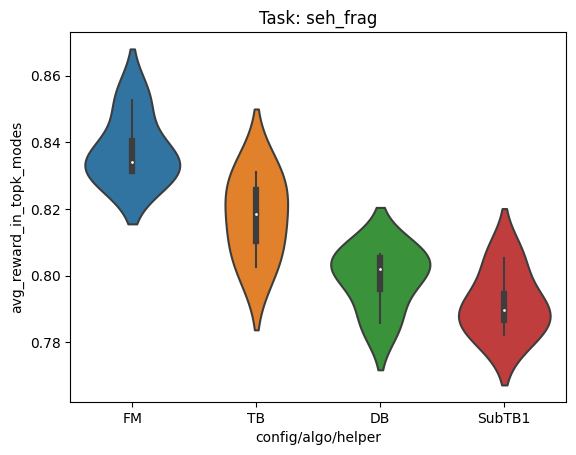

In [26]:
plot_violin = True
plot_top_percent = True
plot_quantile = True

for task in tasks:
    print(f"TASK: {task}")
    df = dfs[task]
    print(df[metric].describe())
    df = df.sort_values(by=metric, ascending=ascending)
    
    # Plot the distribution of the top_percent% of the data
    if plot_top_percent:
        num_head = int(len(df)*top_percent)
        plt.figure()
        plt.title(f"Task: {task}, top {top_percent*100}% of data")
        df.head(num_head)["config/algo/helper"].value_counts().plot(kind="bar")

    # Plot the quantiles
    if plot_quantile:
        quantiles = []
        for method in methods:
            quantiles.append(df[df['config/algo/helper'] == method][metric].quantile(0.05))
        plt.figure()
        plt.title(f"Task: {task}, {percentile}th percentile")
        plt.bar(methods, quantiles)

    # Violin plots
    if plot_violin:
        plt.figure()
        plt.title(f"Task: {task}")
        sns.violinplot(x="config/algo/helper", y=metric, data=df)
    print("\n\n")